# **Generative Adversarial Networks**

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt


def plot_image(image):
    """functions to plot grayscale 28x28 image
        Args:
    """
    plt.imshow(image, cmap="binary")
    plt.axis("off")


def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


## Simple GAN for Fashion MNIST.

Primero, necesitamos construir el **generator** y el **discriminator**. El **generator** es similar
al **Autoencoder's decoder** ,y el **discriminator** es un clasificador
binario regular (toma una imagen como entrada y termina con una capa Densa que
contiene una sola unidad y usa la función de activación sigmoide). Para la segunda
fase de cada iteración de entrenamiento, también necesitamos el modelo GAN
completo que contiene el **generator** seguido del **discriminator**

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

The `trainable attribute` is taken into account by Keras only when compiling a
model, so after running this code, the discriminator is trainable if we call its
fit() method or its train_on_batch() method (which we will be using), while it
is not trainable when we call these methods on the **gan model**.

In [3]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

discriminator.trainable = False
# generator will only be trained through the gan model, so we do not need tocompile it at all.
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")


Since the training loop is unusual, we cannot use the regular **fit()**
method. Instead, we will write a **custom training loop**. For this, we first
need to create a Dataset to iterate through the images:

In [4]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

* In phase one we feed Gaussian noise to the generator to produce
fake images, and we complete this batch by concatenating an
equal number of real images. The targets y1 are set to 0 for fake
images and 1 for real images. Then we train the discriminator on
this batch. 
 
* In phase two, we feed the GAN some Gaussian noise. Its
generator will start by producing fake images, then the
discriminator will try to guess whether these images are fake or
real. We want the discriminator to believe that the fake images are
real, so the targets y2 are set to 1. Note that we set the trainable
attribute to False, once again to avoid a warning

In [10]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            # solo para deshacerse de un Warning que Keras muestra cuando nota que Trainable 
            # ahora es Falso pero era Verdadero cuando el modelo
            discriminator.trainable = True
            
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


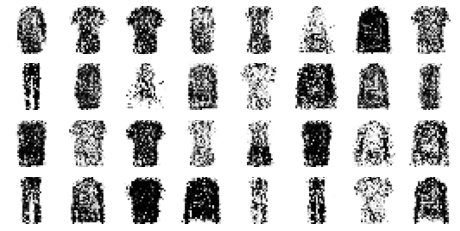

In [11]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

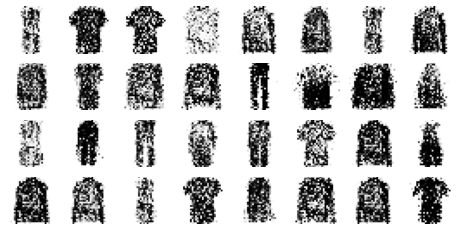

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Desafortunadamente, las imágenes nunca son mucho mejores   imágenes (muy ruidosas) de Fashion
MNIST, e incluso puede encontrar épocas en las que la GAN parece estar olvidando lo que aprendió. ¿Porqué
es eso? Bueno, resulta que entrenar una GAN puede ser un `desafío`.

## Deep Convolutional GAN

**Guidelines they proposed for building stable convolutional GANs:**
* Replace any pooling layers with strided convolutions (in the
discriminator) and transposed convolutions (in the generator).
* Use Batch Normalization in both the generator and the
discriminator, except in the generator’s output layer and the
discriminator’s input layer.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in the generator for all layers except the
output layer, which should use tanh.
* Use leaky ReLU activation in the discriminator for all layers

En el siguiente ejemplo,respetamos las pautas de DCGAN, excepto que reemplazamos las capas
**BatchNormalization** en el discriminador con capas **Dropout** (de lo contrario, el
entrenamiento era inestable en este caso) y reemplazamos **ReLU con SELU** en el generador.
Siéntase libre de modificar esta arquitectura: verá cuán sensible es a los hiperparámetros
(especialmente las tasas de aprendizaje relativas de las dos redes).

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

# regular CNN for binary classification
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")


Como la salida del `generator`(producto de la función tanh) las salidas oscilarán entre -1 y 1.
Por esta razón, antes de entrenar el GAN, necesitamos volver a escalar el conjunto de
entrenamiento a ese mismo rango. También necesitamos remodelarlo para agregar la dimensión
del canal:

In [15]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [17]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/4


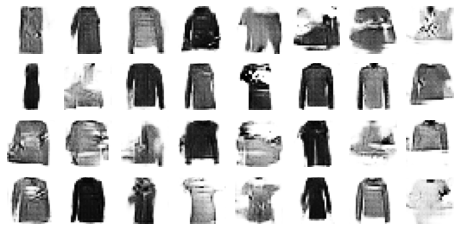

Epoch 2/4


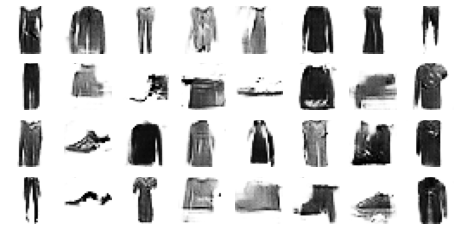

Epoch 3/4


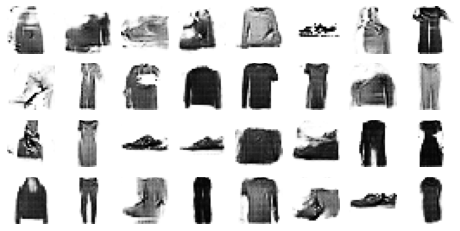

Epoch 4/4


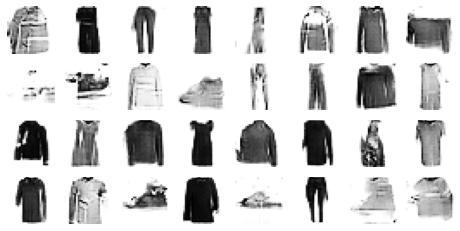

In [20]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=4)


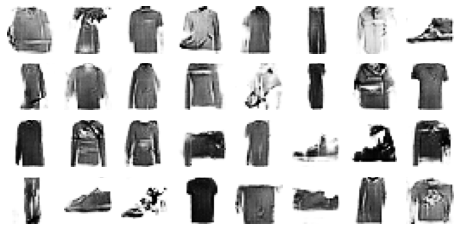

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)